In [2]:
pip install torch chromadb clip-anytorch PIL


  Using cached clip_anytorch-2.6.0-py3-none-any.whl.metadata (8.4 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL

[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


c:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

parent_dir = r'C:\Users\admin\Desktop\dress recognition\clothes-dataset.v2-2022-12-03-7-51pm.clip\train'
images = []
for image_dir in os.listdir(parent_dir):
    image_dir=os.path.join(parent_dir,image_dir)
    print(image_dir)
    image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('jpg', 'png', 'jpeg'))]

    
    for image_file in image_files:
        image = Image.open(image_file)
        image = preprocess(image).unsqueeze(0).to(device)
        images.append((image_file, image))


C:\Users\admin\Desktop\dress recognition\clothes-dataset.v2-2022-12-03-7-51pm.clip\train\long-pants
C:\Users\admin\Desktop\dress recognition\clothes-dataset.v2-2022-12-03-7-51pm.clip\train\long-pants_multiple
C:\Users\admin\Desktop\dress recognition\clothes-dataset.v2-2022-12-03-7-51pm.clip\train\long-sleeve
C:\Users\admin\Desktop\dress recognition\clothes-dataset.v2-2022-12-03-7-51pm.clip\train\long-sleeve_multiple
C:\Users\admin\Desktop\dress recognition\clothes-dataset.v2-2022-12-03-7-51pm.clip\train\short-pants
C:\Users\admin\Desktop\dress recognition\clothes-dataset.v2-2022-12-03-7-51pm.clip\train\short-pants_multiple
C:\Users\admin\Desktop\dress recognition\clothes-dataset.v2-2022-12-03-7-51pm.clip\train\short-sleeve
C:\Users\admin\Desktop\dress recognition\clothes-dataset.v2-2022-12-03-7-51pm.clip\train\short-sleeve_multiple
C:\Users\admin\Desktop\dress recognition\clothes-dataset.v2-2022-12-03-7-51pm.clip\train\sleeveless
C:\Users\admin\Desktop\dress recognition\clothes-dataset

In [3]:
image_embeddings = {}
with torch.no_grad():
    for image_file, image in images:
        embedding = model.encode_image(image)
        embedding /= embedding.norm(dim=-1, keepdim=True)  # Normalize the embeddings
        image_embeddings[image_file] = embedding.cpu().numpy()


In [4]:
import chromadb
from chromadb.config import Settings

# Initialize Chroma DB client with the new settings
client = chromadb.Client(Settings(
    persist_directory=r"C:\Users\admin\Desktop\dress recognition\chroma_db"  # Directory where Chroma DB will be stored
))

# Create a collection for storing image embeddings
collection = client.create_collection(name="image_embeddings")



In [5]:
image_ids=[image[0] for image in images]

In [6]:
embeddings=[image_embedding for image_embedding in image_embeddings.values()] 
embeddings=[list(embedding.flatten().astype(float)) for embedding in embeddings]

In [7]:
chunks=list(zip(image_ids,embeddings))

In [8]:

# Assuming image_embeddings is a dictionary where keys are image file paths
# and values are the corresponding embeddings
for image_id, embedding in chunks:
    collection.add(
        documents=image_id,  # Store the image file path as the document
        ids=image_id,
        embeddings=embedding,  # Store the corresponding embedding
    )

# Persist the database
client = chromadb.PersistentClient(path=r"C:\Users\admin\Desktop\dress recognition\chroma_db")


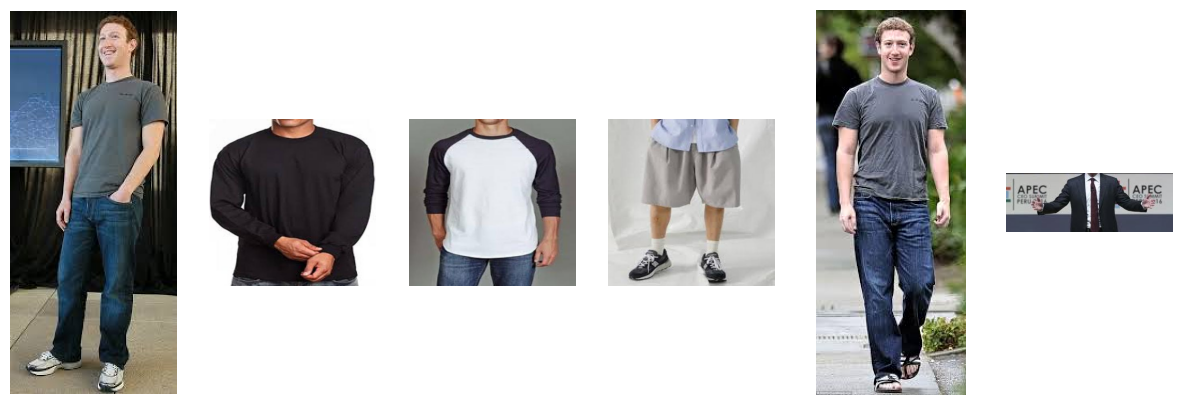

In [12]:
query_image_file=r"C:\Users\admin\Desktop\dress recognition\clothes-dataset.v2-2022-12-03-7-51pm.clip\test\short-sleeve\images (5).jpeg"
query_image = preprocess(Image.open(query_image_file)).unsqueeze(0).to(device)

with torch.no_grad():
    query_embedding = model.encode_image(query_image)
    query_embedding /= query_embedding.norm(dim=-1, keepdim=True)

query_embedding=query_embedding.cpu().numpy()
query_embedding=list(query_embedding.flatten().astype(float))
results = collection.query(
    query_embeddings=query_embedding,
    n_results=5  # Number of similar images to retrieve
)

paths=results['ids']
paths=paths[0]
paths.append(query_image_file)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Create a grid for images
fig, axes = plt.subplots(1, 6, figsize=(15, 5))  # Adjust figsize as needed

# Display each image in the grid
for ax, image_path in zip(axes, paths):
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis('off')  # Hide the axis

# Show the plot
plt.show()




